In [219]:
import pandas as pd
import numpy as np
import copy
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler,LabelEncoder,PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor,RandomForestRegressor,GradientBoostingRegressor 
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_rows', 1300)
pd.set_option('display.max_columns', 1300)
pd.set_option('display.width', 1300)

In [220]:
# prepare data

# loop thr
trainData = pd.read_csv('CS98XRegressionTrain.csv')
trainData = pd.DataFrame(trainData)


testData = pd.read_csv('CS98XRegressionTest_m.csv')
testData = pd.DataFrame(testData)

#print(wholeList)

In [221]:
# check shape of the data
print('train data shape:',trainData.shape)
print('test data shape:',testData.shape)


train data shape: (453, 15)
test data shape: (114, 14)


In [222]:
# check the info of the data
print('train data info:',trainData.info())
print('test data info:',testData.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453 entries, 0 to 452
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Id         453 non-null    int64 
 1   title      453 non-null    object
 2   artist     453 non-null    object
 3   top genre  438 non-null    object
 4   year       453 non-null    int64 
 5   bpm        453 non-null    int64 
 6   nrgy       453 non-null    int64 
 7   dnce       453 non-null    int64 
 8   dB         453 non-null    int64 
 9   live       453 non-null    int64 
 10  val        453 non-null    int64 
 11  dur        453 non-null    int64 
 12  acous      453 non-null    int64 
 13  spch       453 non-null    int64 
 14  pop        453 non-null    int64 
dtypes: int64(12), object(3)
memory usage: 53.2+ KB
train data info: None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------   

In [223]:
# check if duplicate row exist in test data and train data

print('train data duplicated:',trainData.duplicated().any())
print('test data duplicated:',testData.duplicated().any())

train data duplicated: False
test data duplicated: False


In [224]:
# check if any NaN cell in both train and test data
print('train data NaN:',trainData.columns[trainData.isnull().any()])
print('test data NaN:',testData.columns[testData.isnull().any()])


train data NaN: Index(['top genre'], dtype='object')
test data NaN: Index(['top genre'], dtype='object')


In [225]:
# filter out the NaN rows - in train data only, even there are empty in test data, it will be ingore as this is not related to the training
# 1) run drop if empty found
# 2) create a new dataframe that for future use
if not(trainData.columns[trainData.isnull().any()].isnull()):
    trainDataClean = trainData.drop(trainData[trainData['top genre'].isnull()].index)
testDataClean = testData.copy()


In [226]:
# encode the object columns - train data and test data,
# reason: using label encoder and not oneHotEncoder, the size of the new column will created is massive, label encoder is more suitable to turn object(string) to numerical for further analysis
encoder = LabelEncoder()
encodeCols = ["title","artist","top genre"]
for col in encodeCols:
    encoder.fit(trainDataClean[col])
    trainDataClean[col] = encoder.transform(trainDataClean[col])
    
for col in encodeCols:
    encoder.fit(testDataClean[col])
    testDataClean[col] = encoder.transform(testDataClean[col])

In [227]:
# 
print (trainDataClean.describe())


               Id       title      artist   top genre         year         bpm        nrgy        dnce          dB        live         val         dur       acous        spch         pop
count  438.000000  438.000000  438.000000  438.000000   438.000000  438.000000  438.000000  438.000000  438.000000  438.000000  438.000000  438.000000  438.000000  438.000000  438.000000
mean   227.600457  218.038813  162.383562   32.547945  1990.881279  118.326484   60.504566   59.780822   -8.787671   17.605023   59.625571  228.267123   32.191781    5.671233   61.557078
std    130.463047  125.990359   95.913047   26.075252    16.697047   25.175735   22.089660   15.404757    3.591005   13.807492   24.480160   63.426812   29.279912    5.571392   12.759353
min      1.000000    0.000000    0.000000    0.000000  1948.000000   62.000000    7.000000   18.000000  -24.000000    2.000000    6.000000   98.000000    0.000000    2.000000   26.000000
25%    116.250000  109.250000   79.250000    4.000000  1976.00000

In [228]:
# a brief review of encoded and remove empty cell dataframe in train data 
print("train data - after encode:\n",trainDataClean.head())

train data - after encode:
    Id  title  artist  top genre  year  bpm  nrgy  dnce  dB  live  val  dur  acous  spch  pop
0   1    265      54          1  1996  107    31    45  -8    13   28  150     75     3   44
2   3    160      19          1  1979  105    36    63  -9    13   67  245     11     3   77
3   4    422      18          1  1980  170    28    47 -16    13   33  232     25     3   67
4   5    138      92         68  1973  121    47    56  -8    15   40  193     45     3   63
5   6    139      40         80  2010  110    56    71  -7    12   23  223     15     6   74


Text(0.5, 1.0, 'Corelation of all columns')

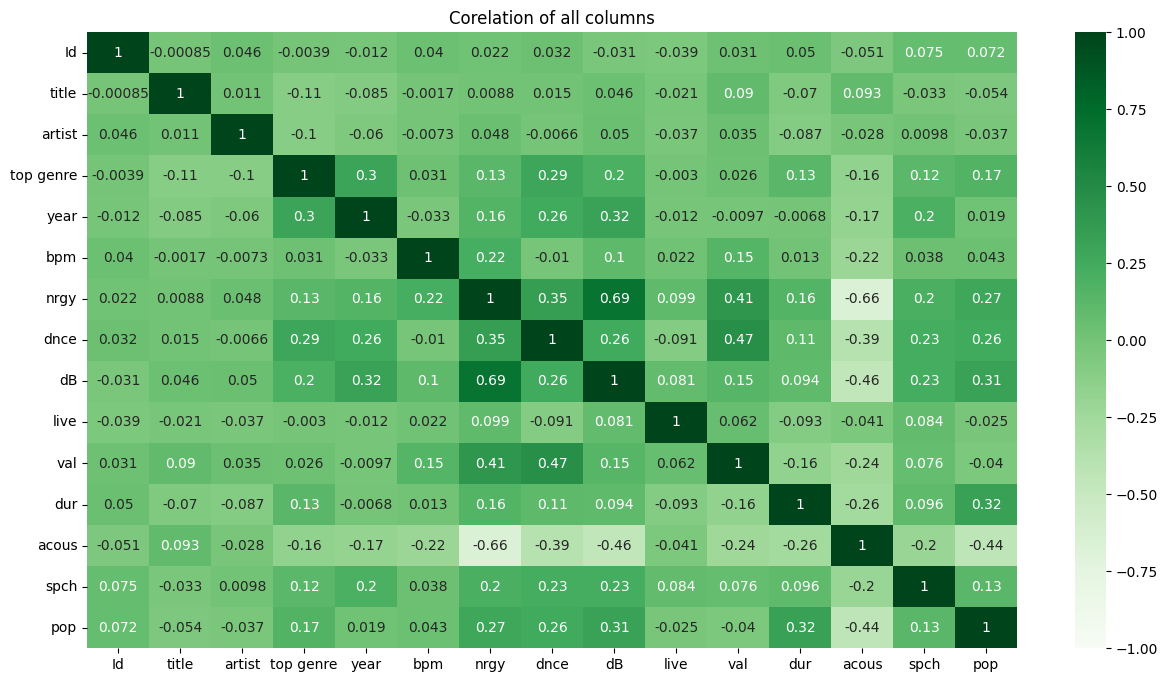

In [229]:
# corelation before remove outliner - train data
corelation = trainDataClean.corr()
fig, ax = plt.subplots(figsize=(15,8))
sns.heatmap(trainDataClean.corr(), center=0, cmap='Greens',vmin=-1, vmax=1, annot=True)
ax.set_title('Corelation of all columns')

In [230]:
# filter the outliner of each columns in train data 
th = 5
outlinerList={}
outlinerCols = trainDataClean.columns
for col in outlinerCols:
    mean = np.mean(trainDataClean[col])
    std=np.std(trainDataClean[col])
    out_list=[]
    for i in trainDataClean[col]:
        z=(i-mean)/std
        if z > th:
            out_list.append(i)
    if (out_list):
        outlinerList[col]= out_list
print("outliers : ", outlinerList)

outliers :  {'live': [93], 'spch': [38, 37, 36, 47]}


In [231]:
# extract outliner in the dataframe and present the shape of dataframe before and after extraction

print("before remove outliner:",trainDataClean.shape)
for key,value in outlinerList.items():
    print(key,value)
    for i in value:
        trainDataClean.drop(trainDataClean[trainDataClean[key]==i].index, inplace = True)

print("after remove outliner:",trainDataClean.shape)

before remove outliner: (438, 15)
live [93]
spch [38, 37, 36, 47]
after remove outliner: (433, 15)


Text(0.5, 1.0, 'Corelation of all columns')

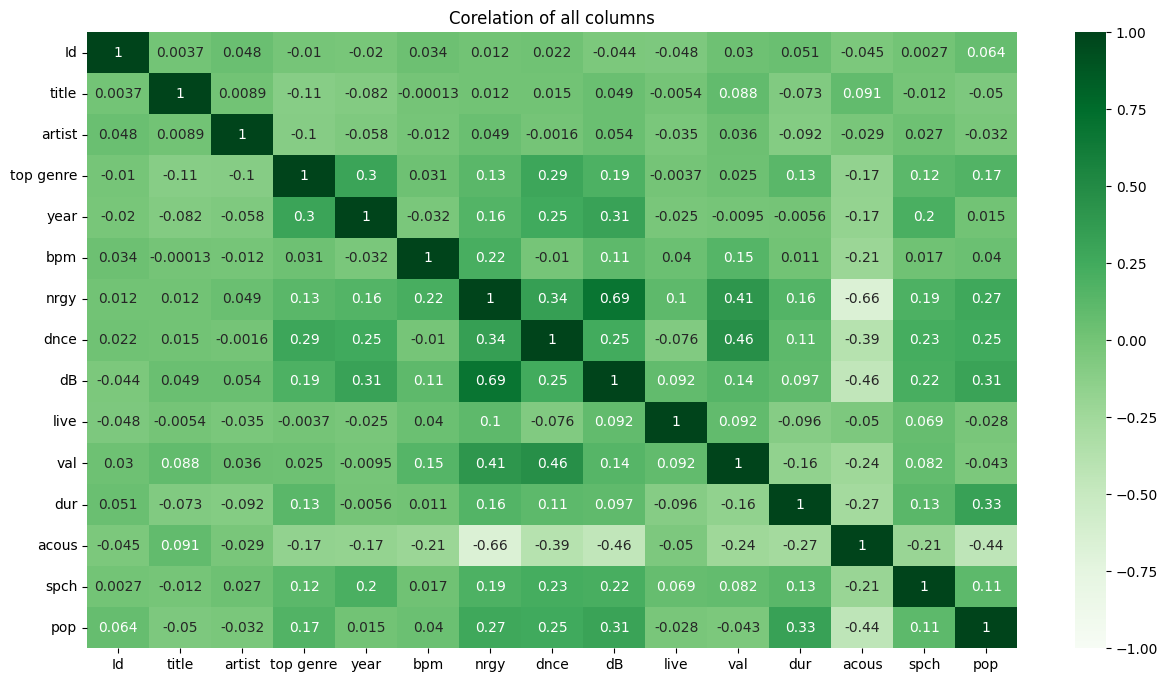

In [232]:
# corelation before remove outliner
corelation = trainDataClean.corr()
fig, ax = plt.subplots(figsize=(15,8))
sns.heatmap(trainDataClean.corr(), center=0, cmap='Greens',vmin=-1, vmax=1, annot=True)
ax.set_title('Corelation of all columns')


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


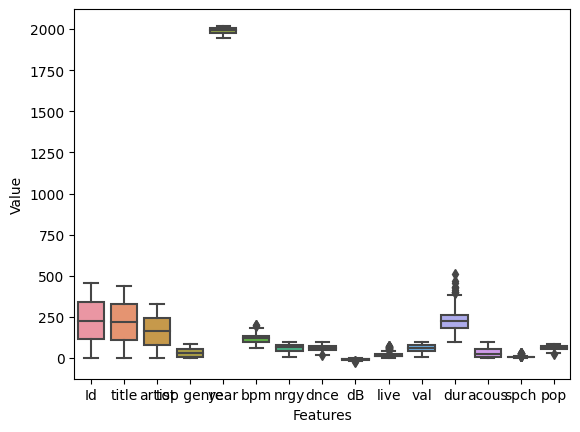

In [233]:
sns.boxplot(data=trainDataClean)
plt.xlabel('Features')
plt.ylabel('Value')
plt.show()

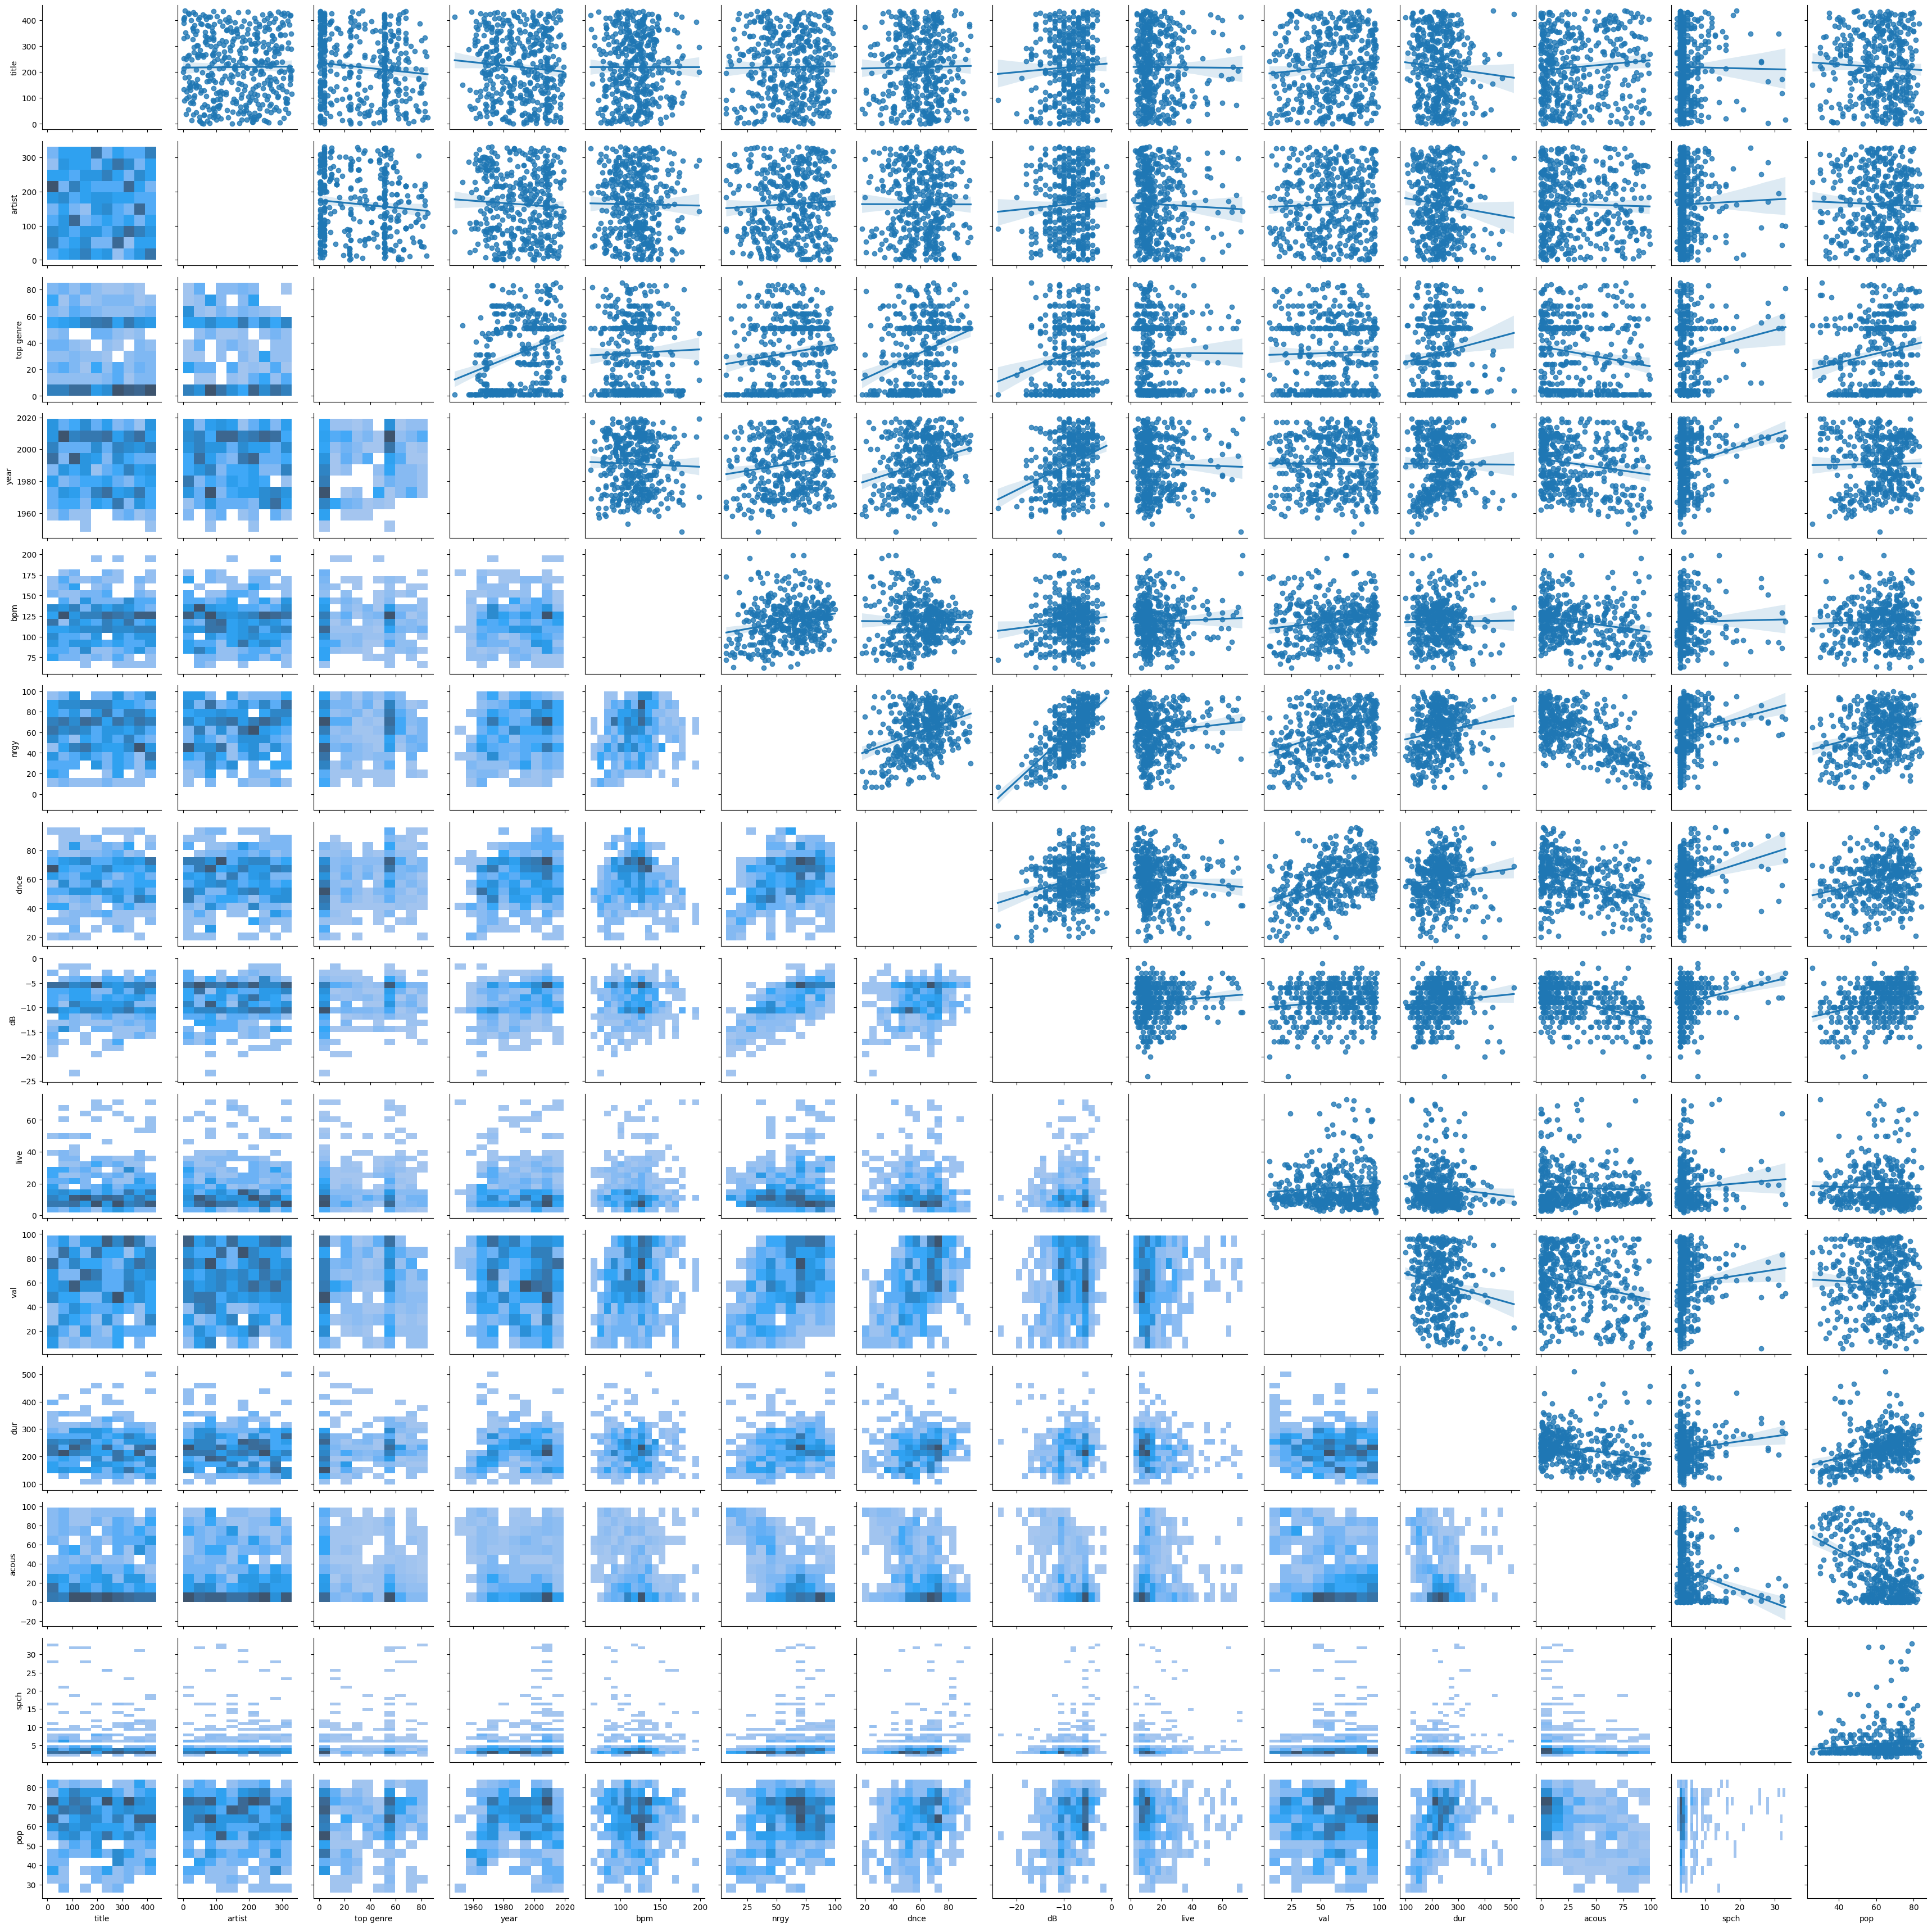

In [234]:
g = sns.PairGrid(trainDataClean.drop(columns=["Id"]))

g.map_upper(sns.regplot)
g.map_lower(sns.histplot)

In [235]:
# after the extraction of outliner and empty cell
# from the corelation matrix, we can find that there are a number of columns that have a correlation over 0.1
# list as following, "top genre","nrgy","dnce","spch","dB","dur","year"
# form the pair grid, we can find there is a trend between "nrgy, db and dnce" and "dur, top genre and pop"

In [236]:
# seperated list - train data

print('train data info:',trainDataClean.info())
print('test data info:',testData.info())

# seperate x and y
y = trainDataClean["pop"]
x = trainDataClean[["top genre","nrgy","dnce","spch","dB","dur","year"]]
# scale the data before using 
stdScaler = StandardScaler()
xScaled = stdScaler.fit_transform(x)

# for polynomial 
polyFeat = PolynomialFeatures(degree=2, include_bias=False)
xPoly = polyFeat.fit_transform(x)
xPolyScaled = stdScaler.fit_transform(xPoly)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 433 entries, 0 to 452
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Id         433 non-null    int64
 1   title      433 non-null    int64
 2   artist     433 non-null    int64
 3   top genre  433 non-null    int64
 4   year       433 non-null    int64
 5   bpm        433 non-null    int64
 6   nrgy       433 non-null    int64
 7   dnce       433 non-null    int64
 8   dB         433 non-null    int64
 9   live       433 non-null    int64
 10  val        433 non-null    int64
 11  dur        433 non-null    int64
 12  acous      433 non-null    int64
 13  spch       433 non-null    int64
 14  pop        433 non-null    int64
dtypes: int64(15)
memory usage: 54.1 KB
train data info: None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0  

In [237]:
# seperate list - test data
#xTest = testDataClean.drop(columns=["top genre","Id","artist","title","year"])
yTest = testDataClean["Id"]
yTestResult = testDataClean["pop"]
xTest = testDataClean[["top genre","nrgy","dnce","spch","dB","dur","year"]]

stdScaler = StandardScaler()
xScaledTest = stdScaler.fit_transform(xTest)

polyFeat = PolynomialFeatures(degree=2, include_bias=False)
xPolyScaledTest = polyFeat.fit_transform(xTest)
xPolyScaledTest = stdScaler.fit_transform(xPolyScaledTest)

In [238]:
# 1)Decision Tree Regression
# scaled x is not applied for this sample as decision tree do not require scaling
tree = DecisionTreeRegressor(min_samples_leaf=5) 
tree.fit(x,y)
predTreeTest = tree.predict(xTest) 
print(predTreeTest)
predTestdf = pd.DataFrame(predTreeTest)
result = pd.concat([yTest, predTestdf], axis=1, ignore_index=True)
result = result.set_axis(['Id','pop'], axis=1)
print(result.columns)
result.to_csv("my_data_tree_Grp3.csv",index=False,header="Id,pop")

[75.125      64.25       55.88888889 63.         52.2        58.28571429
 58.4        41.         63.5        69.4        55.88888889 75.55555556
 55.88888889 55.88888889 72.83333333 50.         62.42857143 63.375
 60.4        60.4        51.77777778 62.42857143 59.4        46.
 55.         66.2        63.         47.         52.2        71.
 75.55555556 53.88888889 71.         71.4        70.8        75.125
 67.         58.4        63.375      74.42857143 69.66666667 60.71428571
 62.         59.4        58.4        55.88888889 63.375      58.
 71.25       71.25       52.2        60.71428571 69.66666667 46.
 64.25       72.         60.71428571 40.6        72.5        41.
 74.42857143 71.66666667 71.25       66.2        75.125      66.66666667
 60.71428571 55.88888889 58.28571429 43.         75.125      55.16666667
 55.         67.         55.88888889 74.42857143 75.125      75.55555556
 71.25       71.         69.4        63.375      40.6        74.42857143
 40.6        47.         60.

In [239]:
# 2) poly SVR
# instead of scaled x , we use scaled polynomial featured x (degree=2)as we are going to apply poly SVR(degree=2))
svrPoly = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svrPoly.fit(xPolyScaled,y)
predSVRPolyTest = svrPoly.predict(xPolyScaledTest) 
print(predSVRPolyTest)
predTestdf = pd.DataFrame(predSVRPolyTest)
result = pd.concat([yTest, predTestdf], axis=1, ignore_index=True)
result = result.set_axis(['Id','pop'], axis=1)
print(result.columns)
result.to_csv("my_data_SVR_Grp3.csv",index=False,header="Id,pop")


linearMse = mean_squared_error(yTestResult, predSVRPolyTest)
linearRmse = np.sqrt(linearMse)
print("test linearRmse",linearRmse)

[ 79.91210046  65.08818353  64.89974626  55.7767397   40.88587346
  68.98524121  63.13472261  53.30053838  61.45007527  68.25694269
  47.53888401  70.74314042  59.83720526  63.19106629  67.78527703
  62.19422011  58.91727095  66.46221692  77.04202893  63.94880283
  66.62237533  55.39539124  54.32480435  45.24037273  53.24784552
  67.85063486  61.78173968  61.75680685  47.06431478  82.37371557
  71.04693425  49.43153172  70.85913561  66.269382    68.25815505
  84.03667298  72.39497717  60.97820794  60.16727133  67.35652872
  70.58541335  60.01727712  63.56141545  49.51102886  64.13566943
  62.09776942  77.30671137  68.0268388   64.95350764  65.5085624
  49.46886562  75.88944354  73.92028999  34.40491137  66.99288361
  61.34864674  69.38722959  52.93452264  73.29496135  51.85024816
  66.62483161  75.21872502  62.87748807  63.78505035  79.16752755
  62.46306865  71.48801228  59.48456682  68.32156039  69.9338495
  67.77785576  51.38052474  61.14633578  70.59862003  64.74394887
  74.6458949

In [240]:
# 3) bagging with polySVR
baggedPolySVRReg = BaggingRegressor(base_estimator=SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale"),n_estimators=10, random_state=0,bootstrap=True, n_jobs=-1)
baggedPolySVRReg.fit(xPolyScaled,y)
predbaggedSVRPolyTest = baggedPolySVRReg.predict(xPolyScaledTest)     
print(predbaggedSVRPolyTest)
predTestdf = pd.DataFrame(predbaggedSVRPolyTest)
result = pd.concat([yTest, predTestdf], axis=1, ignore_index=True)
result = result.set_axis(['Id','pop'], axis=1)
print(result.columns)
result.to_csv("my_data_Bagged_SVR_Grp3.csv",index=False,header="Id,pop")

linearMse = mean_squared_error(yTestResult, predbaggedSVRPolyTest)
linearRmse = np.sqrt(linearMse)
print("test linearRmse",linearRmse)

[77.73156861 66.83032189 62.59515771 55.64274797 41.43254837 69.01239536
 62.23725185 51.82519859 59.33932584 66.3230955  48.72685949 67.91324146
 58.2909167  62.84688996 69.02173566 60.05359634 56.84704209 66.70818804
 78.03833766 66.07757693 64.41761806 53.66628974 53.29685729 46.62363756
 42.16929063 67.96116901 62.60743888 62.01814788 49.30253224 83.22093131
 74.81188713 48.02434227 67.8137907  67.36684602 67.2340411  82.80806959
 70.60088508 61.04625696 61.04482034 66.24062237 71.15375296 59.13156737
 64.16443173 50.78408598 64.40823966 63.19106803 73.41283298 66.92632326
 63.92548939 66.75408148 51.47735897 77.38330018 74.22169997 39.35014478
 69.47114789 62.78183644 67.43242559 51.08661947 73.91557341 49.83626493
 65.39692801 74.41251292 64.21363754 64.88718272 79.4495485  57.09615139
 83.90807036 59.128281   67.15983781 70.1264847  69.88699512 48.11817228
 60.29916026 71.19306559 65.16802207 72.47482869 72.76090814 79.33062761
 69.52908414 59.60856943 66.81445057 78.58847596 56

In [241]:
# 4) bagging with randomForest
baggedRFReg = BaggingRegressor(base_estimator=RandomForestRegressor(max_leaf_nodes=50, n_jobs=-1),n_estimators=10, random_state=0,bootstrap=True, n_jobs=-1)
baggedRFReg.fit(xPolyScaled,y)
predbaggedRFTest = baggedRFReg.predict(xPolyScaledTest)     
print(predbaggedRFTest)
predTestdf = pd.DataFrame(predbaggedRFTest)
result = pd.concat([yTest, predTestdf], axis=1, ignore_index=True)
result = result.set_axis(['Id','pop'], axis=1)
print(result.columns)
result.to_csv("my_data_bagged_RF_Grp3.csv",index=False,header="Id,pop")


linearMse = mean_squared_error(yTestResult, predbaggedRFTest)
linearRmse = np.sqrt(linearMse)
print("test linearRmse",linearRmse)

[70.20374066 61.73676758 55.86467943 61.74949884 46.26785146 65.11971824
 59.01970096 43.51193955 62.29779618 64.74691665 54.65982776 68.77894894
 56.33238783 59.62557121 68.89006014 60.23190678 57.66122998 64.17778039
 68.62525437 67.38610704 57.81104933 56.14019597 47.54478647 51.05215045
 54.9119458  63.86163186 60.88314201 57.23585153 48.09817784 69.90057662
 69.11307436 53.13000806 64.32875032 70.63662457 65.43904644 72.34348803
 70.21459535 57.83614979 62.21117178 67.66273071 68.68663431 60.72262737
 61.76118688 45.38437942 58.61901053 59.88177502 66.22033858 61.56978995
 62.24983112 62.99897635 52.828636   66.09717796 68.82169695 50.52496887
 61.42427137 61.84723489 63.72012601 50.96337737 71.19515341 46.90615403
 63.48924738 66.78591804 64.21888119 63.98083512 70.87452603 61.53345358
 63.77674699 53.62650515 67.94518059 56.70835697 68.69733358 49.72866955
 55.78622735 67.23931797 57.43227324 68.60910306 69.52626843 66.33522829
 60.99098984 56.16043186 65.37282984 62.73037212 47

In [242]:
# check the importance of each feature
rf = RandomForestRegressor(max_leaf_nodes=50, n_jobs=-1)
rf.fit(xScaled,y)
rf.feature_importances_

array([0.08179921, 0.11494555, 0.07828432, 0.04924074, 0.08499615,
       0.41312671, 0.17760731])

In [243]:
# 5) Gradient Boosting Regressor
gradBoostReg = GradientBoostingRegressor(random_state=0)
gradBoostReg.fit(xScaled,y)
predGradBoostReg = gradBoostReg.predict(xScaledTest)     
print(predGradBoostReg)

predTestdf = pd.DataFrame(predGradBoostReg)
result = pd.concat([yTest, predTestdf], axis=1, ignore_index=True)
result = result.set_axis(['Id','pop'], axis=1)
print(result.columns)
result.to_csv("my_data_grad_boost_Grp3.csv",index=False,header="Id,pop")

linearMse = mean_squared_error(yTestResult, predGradBoostReg)
linearRmse = np.sqrt(linearMse)
print("test linearRmse",linearRmse)

[71.68737275 68.78074191 64.39507172 62.4920472  41.52115805 67.40487054
 63.76460828 42.2329036  59.60564103 65.21753456 55.34143471 66.96141942
 64.77151739 62.20770732 68.15866517 57.33390557 64.16874149 63.93429437
 70.30600234 67.44381133 51.5990023  56.79654594 52.2238418  49.45787167
 54.80164918 67.59247333 61.46009097 48.82147658 41.08059874 69.60728621
 68.23127882 54.23718157 65.24780036 69.34117797 66.01789355 76.60455939
 68.62910554 62.90052673 61.6945915  73.47555856 68.40156906 59.35990533
 65.14603607 43.49157223 64.9226038  59.66429206 70.6795074  62.44813149
 65.50984894 66.20876907 47.08937935 70.90720601 69.61989194 51.04210175
 67.65290526 62.009264   65.05501524 51.03517654 69.80981668 49.47549095
 62.19541964 69.69556223 67.06769829 65.34736105 70.58707192 65.19068327
 59.42825628 66.5685967  68.23072017 48.29642612 69.15941527 49.0223983
 53.91131194 65.142266   58.86106522 68.82633769 72.87313442 68.06864579
 64.28736711 59.71802508 66.83302251 69.39180966 52.